In [35]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import os
from tqdm import tqdm, tqdm_notebook
import random
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.applications import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.initializers import *
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import img_to_array, array_to_img
from keras.preprocessing import image
from sklearn.metrics import *
from sklearn.metrics import confusion_matrix, classification_report

from tensorflow.keras.applications import ResNet50, VGG16
import imageio
import cv2
from typing import Dict


In [2]:
#seeds:
np.random.seed(123)
tf.random.set_seed(123)

# Data Loading

In [3]:
artist_df = pd.read_csv('./Data/artists.csv', sep=",")

In [4]:
artist_df.head()

id                name        years                         genre  \
0   0   Amedeo Modigliani  1884 - 1920                 Expressionism   
1   1  Vasiliy Kandinskiy  1866 - 1944  Expressionism,Abstractionism   
2   2        Diego Rivera  1886 - 1957       Social Realism,Muralism   
3   3        Claude Monet  1840 - 1926                 Impressionism   
4   4       Rene Magritte  1898 - 1967      Surrealism,Impressionism   

  nationality                                                bio  \
0     Italian  Amedeo Clemente Modigliani (Italian pronunciat...   
1     Russian  Wassily Wassilyevich Kandinsky (Russian: Васи́...   
2     Mexican  Diego María de la Concepción Juan Nepomuceno E...   
3      French  Oscar-Claude Monet (; French: [klod mɔnɛ]; 14 ...   
4     Belgian  René François Ghislain Magritte (French: [ʁəne...   

                                        wikipedia  paintings  
0  http://en.wikipedia.org/wiki/Amedeo_Modigliani        193  
1  http://en.wikipedia.org/wiki/Wassily_Kandinsky         88  
2       http://en.wikipedia.org/wiki/Diego_Rivera         70  
3       http://en.wikipedia.org/wiki/Claude_Monet         73  
4      http://en.wikipedia.org/wiki/René_Magritte        194

In [5]:
images_dir = './Data/resized'

# Data Processing

In [6]:
# Sort artists by number of paintings
artists = artist_df.sort_values(by=['paintings'], ascending=False)

# Create a dataframe with artists having more than 200 paintings
artists_top = artists[artists['paintings'] >= 200].reset_index()
artists_top = artists_top[['name', 'paintings']]
#artists_top['class_weight'] = max(artists_top.paintings)/artists_top.paintings
artists_top['class_weight'] = artists_top.paintings.sum() / (artists_top.shape[0] * artists_top.paintings)
artists_top

name  paintings  class_weight
0        Vincent van Gogh        877      0.445631
1             Edgar Degas        702      0.556721
2           Pablo Picasso        439      0.890246
3   Pierre-Auguste Renoir        336      1.163149
4          Albrecht Dürer        328      1.191519
5            Paul Gauguin        311      1.256650
6          Francisco Goya        291      1.343018
7               Rembrandt        262      1.491672
8           Alfred Sisley        259      1.508951
9                  Titian        255      1.532620
10           Marc Chagall        239      1.635223

In [7]:
# Set class weights - assign higher weights to underrepresented classes
class_weights = artists_top['class_weight'].to_dict()
class_weights

{0: 0.44563076604125634,
 1: 0.5567210567210568,
 2: 0.8902464278318493,
 3: 1.1631493506493507,
 4: 1.1915188470066518,
 5: 1.2566501023092662,
 6: 1.3430178069353327,
 7: 1.491672449687717,
 8: 1.5089505089505089,
 9: 1.532620320855615,
 10: 1.6352225180677062}

In [8]:
# There is some problem recognizing 'Albrecht_Dürer' (don't know why, worth exploring)
# So I'll update this string as directory name to df's
updated_name = "Albrecht_Dürer".replace("_", " ")
artists_top.iloc[4, 0] = updated_name

In [9]:
artists_top_name = artists_top['name'].str.replace(' ', '_').values

In [10]:
artists_top_name

array(['Vincent_van_Gogh', 'Edgar_Degas', 'Pablo_Picasso',
       'Pierre-Auguste_Renoir', 'Albrecht_Dürer', 'Paul_Gauguin',
       'Francisco_Goya', 'Rembrandt', 'Alfred_Sisley', 'Titian',
       'Marc_Chagall'], dtype=object)

# Data Visualization

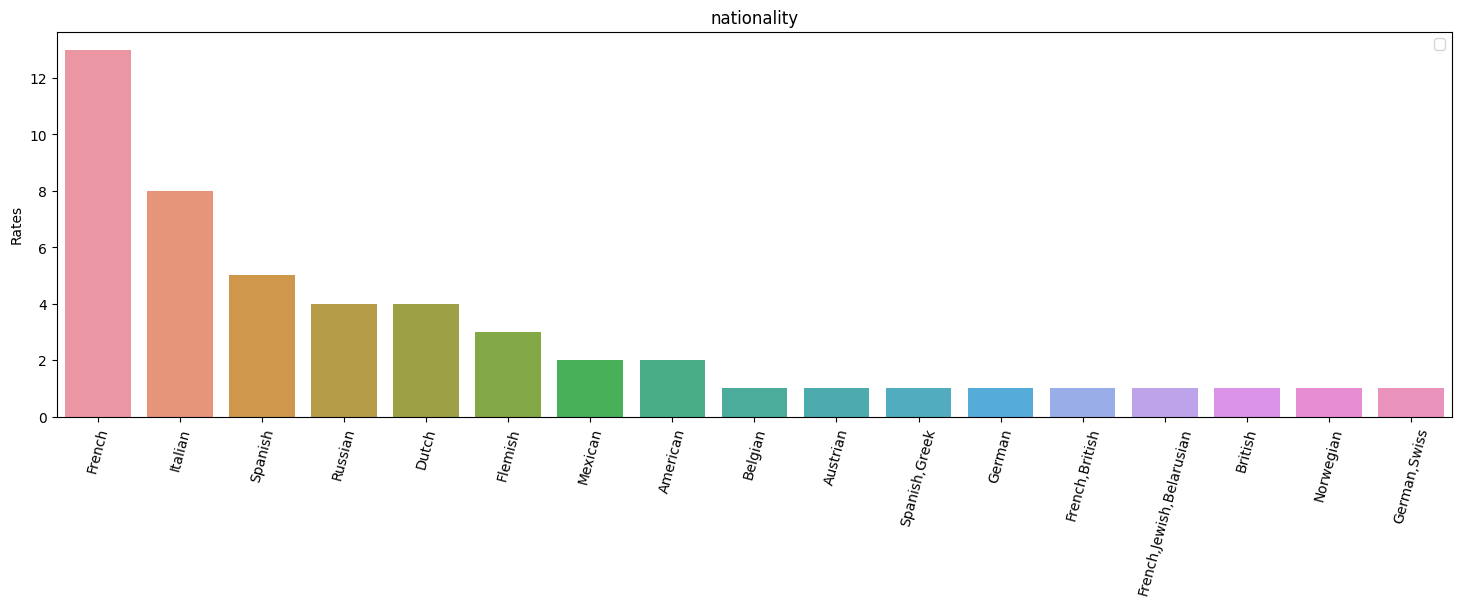

In [11]:
plt.figure(figsize=(18,5))

sns.barplot(x=artist_df['nationality'].value_counts().index,y=artist_df['nationality'].value_counts().values)
plt.title('nationality')
plt.xticks(rotation=75)
plt.ylabel('Rates')
plt.legend(loc=0)
plt.show()

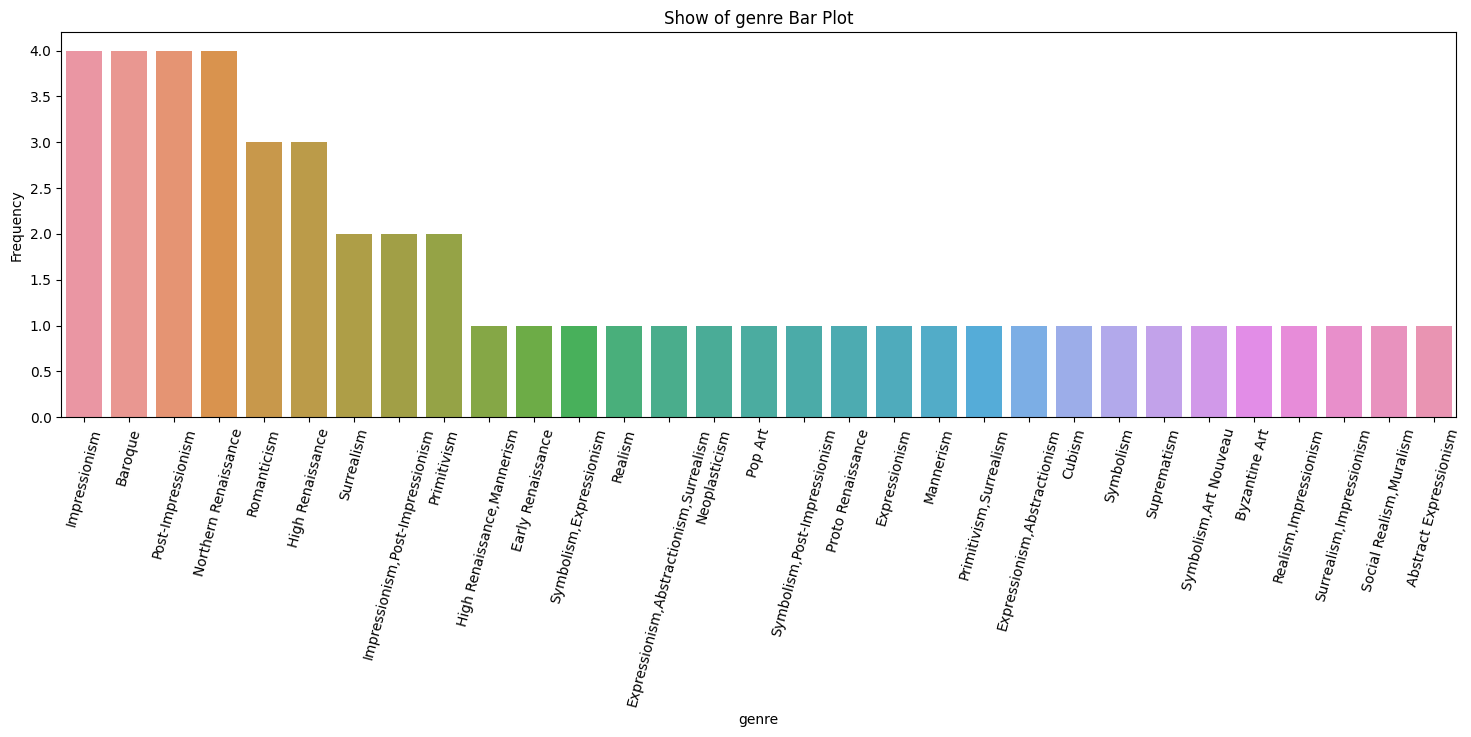

In [12]:
plt.figure(figsize=(18,5))
sns.barplot(x=artist_df['genre'].value_counts().index,
              y=artist_df['genre'].value_counts().values)
plt.xlabel('genre')
plt.xticks(rotation=75)
plt.ylabel('Frequency')
plt.title('Show of genre Bar Plot')
plt.show()

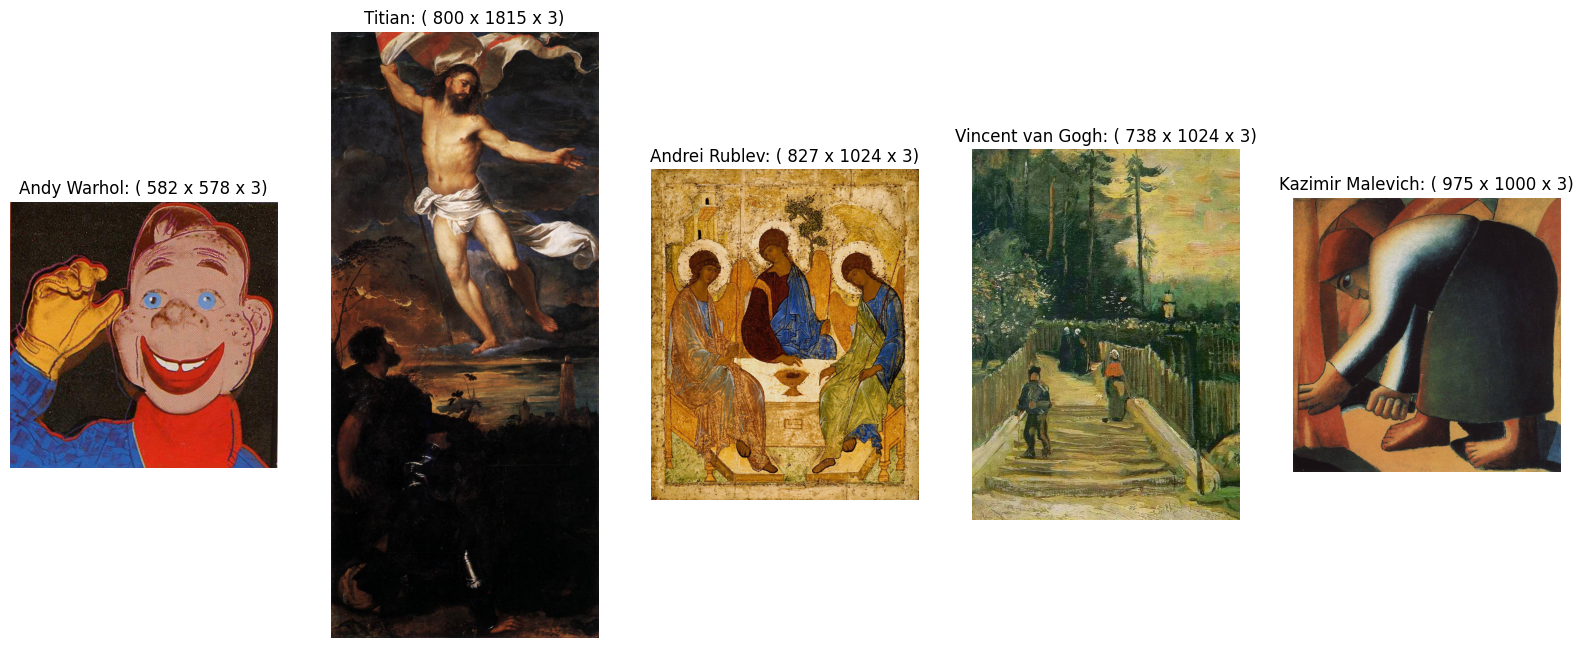

In [13]:
fig, axes = plt.subplots(1, 5, figsize=(20,10))

for i in range(5):
    random_image = random.choice(os.listdir(os.path.join(images_dir)))
    random_image_file = os.path.join(images_dir, random_image)
    image = plt.imread(random_image_file)

    # Get the shape of the image
    height, width, channels = image.shape
    artist_name = " ".join(random_image.split("_")[:-1])

    axes[i].imshow(image)
    axes[i].set_title(artist_name+ f": ( {width} x {height} x {channels})")
    axes[i].axis('off')

plt.show()

# Train and Test Split

In [14]:
# Create a DataFrame to store filename and artist mapping
file_artist_mapping = []

for filename in os.listdir(images_dir):
    if filename.endswith(('.png', '.jpg', '.jpeg')):

        artist_name = "_".join(filename.split("_")[:-1])

        if (artist_name in artists_top_name) or artist_name=='Albrecht_Dürer':
          artist_name = artist_name.replace('_',' ')
          file_artist_mapping.append({'filename': filename, 'artist': artist_name})


df = pd.DataFrame(file_artist_mapping)

# Define image size and other parameters
img_size = (224, 224)
batch_size = 16
n_classes = artists_top.shape[0]
train_input_shape = (224, 224, 3)
# Create data generators
datagen = ImageDataGenerator(validation_split=0.2,
                                   rescale=1./255.,

                                   shear_range=5,

                                   horizontal_flip=True,
                                   vertical_flip=True,)
# Train generator
train_generator = datagen.flow_from_dataframe(
    dataframe=df,
    directory=images_dir,
    x_col='filename',
    y_col='artist',
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)
# Validation generator
validation_generator = datagen.flow_from_dataframe(
    dataframe=df,
    directory=images_dir,
    x_col='filename',
    y_col='artist',
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)

STEP_SIZE_TRAIN = train_generator.n//train_generator.batch_size
STEP_SIZE_VALID = validation_generator.n//validation_generator.batch_size
print("Total number of batches =", STEP_SIZE_TRAIN, "and", STEP_SIZE_VALID)

Found 3440 validated image filenames belonging to 11 classes.
Found 859 validated image filenames belonging to 11 classes.
Total number of batches = 215 and 53


# Data Augmentation Visualization

In [15]:
def transformed_image_visualization(images_dir: str, artists_top_name: List[str], datagen: ImageDataGenerator) -> None:
    """
    Display an original image and its randomly transformed version for a random artist.

    Parameters:
    - images_dir (str): Directory path containing images.
    - artists_top_name (List[str]): List of artist names.
    - datagen (ImageDataGenerator): ImageDataGenerator for data augmentation.

    Returns:
    None
    """
    # Create subplots for original and transformed images
    fig, axes = plt.subplots(1, 2, figsize=(20, 10))

    # Randomly choose an artist and an image for visualization
    random_artist = random.choice(artists_top_name)
    random_image = random.choice(os.listdir(os.path.join(images_dir)))
    random_image_file = os.path.join(images_dir, random_image)

    # Load and display the original image
    image = plt.imread(random_image_file)
    axes[0].imshow(image)
    axes[0].set_title("An original Image of " + random_artist.replace('_', ' '))
    axes[0].axis('off')

    # Apply random transformation using the provided ImageDataGenerator
    aug_image = datagen.random_transform(image)

    # Display the transformed image
    axes[1].imshow(aug_image)
    axes[1].set_title("A transformed Image of " + random_artist.replace('_', ' '))
    axes[1].axis('off')

    # Show the plot
    plt.show()


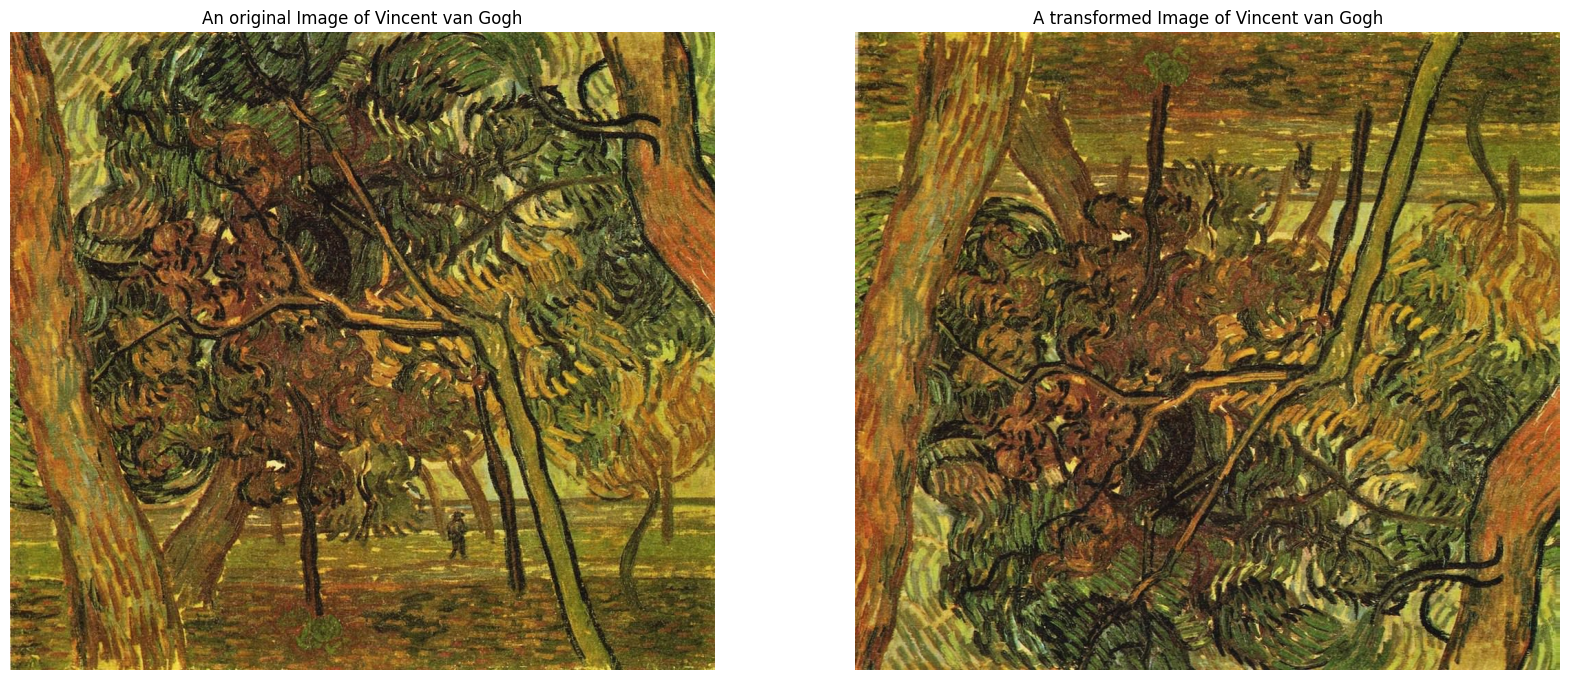

In [17]:
transformed_image_visualization()

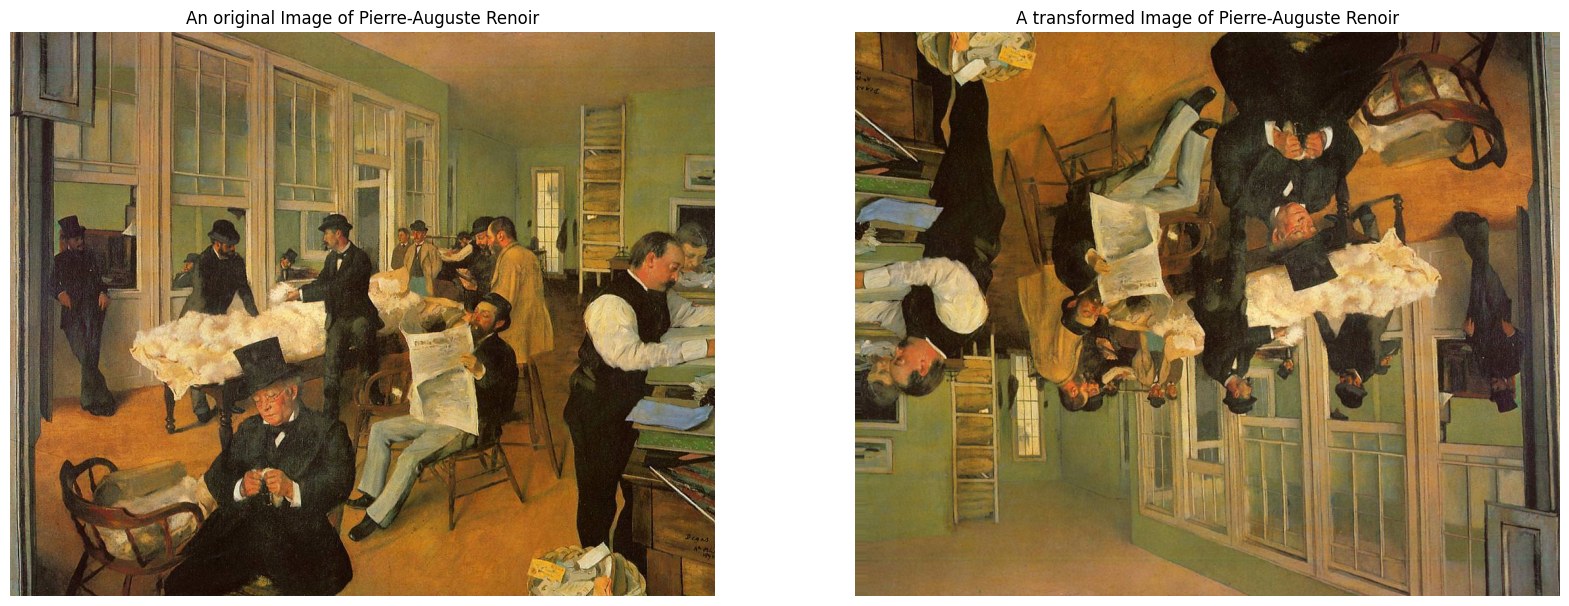

In [16]:
transformed_image_visualization()

# Transfer Learning

## VCG-16

In [19]:
def build_custom_model(base_model: Model, n_classes: int, dense_units: list[int] = [512, 16], activation: str = 'relu') -> Model:
    """
    Build a custom model on top of a base model.

    Parameters:
    - base_model (Model): Base model on top of which the custom model will be built.
    - n_classes (int): Number of output classes for the final softmax layer.
    - dense_units (list[int]): List of units for dense layers. Default is [512, 16].
    - activation (str): Activation function for dense layers. Default is 'relu'.

    Returns:
    Model: The custom model.
    """
    # Flatten the output of the base model
    x = Flatten()(base_model.output)

    # Add dense layers with batch normalization and activation
    for units in dense_units:
        x = Dense(units, kernel_initializer='he_uniform')(x)
        x = BatchNormalization()(x)
        x = Activation(activation)(x)

    # Output layer with softmax activation for classification
    output = Dense(n_classes, activation='softmax')(x)

    # Create the custom model
    model = Model(inputs=base_model.input, outputs=output)

    return model


# Load pre-trained models
base_model_vgg16 = VGG16(weights='imagenet', include_top=False, input_shape=train_input_shape)
for layer in base_model_vgg16.layers:
    layer.trainable = True

# Build custom models

model_vgg16 = build_custom_model(base_model_vgg16, n_classes)


# Compile and train VGG16
optimizer_vgg16 = Adam(learning_rate=0.0001)
model_vgg16.compile(loss='categorical_crossentropy',
                    optimizer=optimizer_vgg16,
                    metrics=['accuracy'])

early_stop_vgg16 = EarlyStopping(monitor='val_loss', patience=20, verbose=1,
                                mode='auto', restore_best_weights=True)

history_vgg16 = model_vgg16.fit_generator(generator=train_generator, steps_per_epoch=STEP_SIZE_TRAIN,
                                          validation_data=validation_generator, validation_steps=STEP_SIZE_VALID,
                                          epochs=10,
                                          shuffle=True,
                                          verbose=1,
                                          callbacks=[early_stop_vgg16],
                                          class_weight=class_weights)

<ipython-input-19-4e629797ef70>:36: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history_vgg16 = model_vgg16.fit_generator(generator=train_generator, steps_per_epoch=STEP_SIZE_TRAIN,


Epoch 1/10
215/215 [==============================] - 103s 425ms/step - loss: 2.5845 - accuracy: 0.2666 - val_loss: 4.7300 - val_accuracy: 0.1061
Epoch 2/10
215/215 [==============================] - 88s 407ms/step - loss: 2.2352 - accuracy: 0.3991 - val_loss: 2.1093 - val_accuracy: 0.2854
Epoch 3/10
215/215 [==============================] - 86s 400ms/step - loss: 1.9815 - accuracy: 0.5134 - val_loss: 2.3677 - val_accuracy: 0.3915
Epoch 4/10
215/215 [==============================] - 85s 398ms/step - loss: 1.8475 - accuracy: 0.5648 - val_loss: 1.6867 - val_accuracy: 0.5259
Epoch 5/10
215/215 [==============================] - 90s 421ms/step - loss: 1.7449 - accuracy: 0.5948 - val_loss: 1.6285 - val_accuracy: 0.4705
Epoch 6/10
215/215 [==============================] - 105s 487ms/step - loss: 1.5852 - accuracy: 0.6323 - val_loss: 1.8146 - val_accuracy: 0.4269
Epoch 7/10
215/215 [==============================] - 86s 399ms/step - loss: 1.4906 - accuracy: 0.6520 - val_loss: 1.4076 - val_

## Resnet50

In [20]:
# Load pre-trained models
base_model_resnet50 = ResNet50(weights='imagenet', include_top=False, input_shape=train_input_shape)

# Build custom models
model_resnet50 = build_custom_model(base_model_resnet50, n_classes)
# Compile and train ResNet50
optimizer_resnet50 = Adam(learning_rate=0.0001)
model_resnet50.compile(loss='categorical_crossentropy',
                       optimizer=optimizer_resnet50,
                       metrics=['accuracy'])

early_stop_resnet50 = EarlyStopping(monitor='val_loss', patience=20, verbose=1,
                                    mode='auto', restore_best_weights=True)

history_resnet50 = model_resnet50.fit_generator(generator=train_generator, steps_per_epoch=STEP_SIZE_TRAIN,
                                                validation_data=validation_generator, validation_steps=STEP_SIZE_VALID,
                                                epochs=10,
                                                shuffle=True,
                                                verbose=1,
                                                callbacks=[early_stop_resnet50],
                                                class_weight=class_weights)

<ipython-input-20-fc60169746d9>:15: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history_resnet50 = model_resnet50.fit_generator(generator=train_generator, steps_per_epoch=STEP_SIZE_TRAIN,


Epoch 1/10
215/215 [==============================] - 129s 442ms/step - loss: 2.0812 - accuracy: 0.4756 - val_loss: 4.2708 - val_accuracy: 0.0778
Epoch 2/10
215/215 [==============================] - 101s 467ms/step - loss: 1.5145 - accuracy: 0.7328 - val_loss: 2.5936 - val_accuracy: 0.0743
Epoch 3/10
215/215 [==============================] - 93s 433ms/step - loss: 1.2919 - accuracy: 0.7956 - val_loss: 2.5301 - val_accuracy: 0.1002
Epoch 4/10
215/215 [==============================] - 108s 501ms/step - loss: 1.1104 - accuracy: 0.8462 - val_loss: 2.0085 - val_accuracy: 0.3608
Epoch 5/10
215/215 [==============================] - 103s 481ms/step - loss: 0.9771 - accuracy: 0.8654 - val_loss: 1.4573 - val_accuracy: 0.6498
Epoch 6/10
215/215 [==============================] - 95s 439ms/step - loss: 0.8758 - accuracy: 0.8890 - val_loss: 0.9353 - val_accuracy: 0.8125
Epoch 7/10
215/215 [==============================] - 91s 423ms/step - loss: 0.7714 - accuracy: 0.9035 - val_loss: 1.0266 - va

# Model Evaluation

In [21]:
def evaluate(model, generator, verbose=1):
    score = model.evaluate_generator(generator, verbose=verbose)
    return score[1]

# Assuming you have trained models: model_resnet50, model_vgg16
accuracy_resnet50_train = evaluate(model_resnet50, train_generator)
accuracy_resnet50_cv = evaluate(model_resnet50, validation_generator)

accuracy_vgg16_train = evaluate(model_vgg16, train_generator)
accuracy_vgg16_cv = evaluate(model_vgg16, validation_generator)

print("ResNet50 - Prediction accuracy on train data =", accuracy_resnet50_train)
print("ResNet50 - Prediction accuracy on CV data =", accuracy_resnet50_cv)

print("VGG16 - Prediction accuracy on train data =", accuracy_vgg16_train)
print("VGG16 - Prediction accuracy on CV data =", accuracy_vgg16_cv)


<ipython-input-21-c5c8f516f0c5>:2: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  score = model.evaluate_generator(generator, verbose=verbose)


54/54 [==============================] - 18s 334ms/step - loss: 1.2777 - accuracy: 0.6298
ResNet50 - Prediction accuracy on train data = 0.9720930457115173
ResNet50 - Prediction accuracy on CV data = 0.8381839394569397
VGG16 - Prediction accuracy on train data = 0.6857557892799377
VGG16 - Prediction accuracy on CV data = 0.6298021078109741


In [23]:
model_vgg16.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [22]:
model_resnet50.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_2[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                        

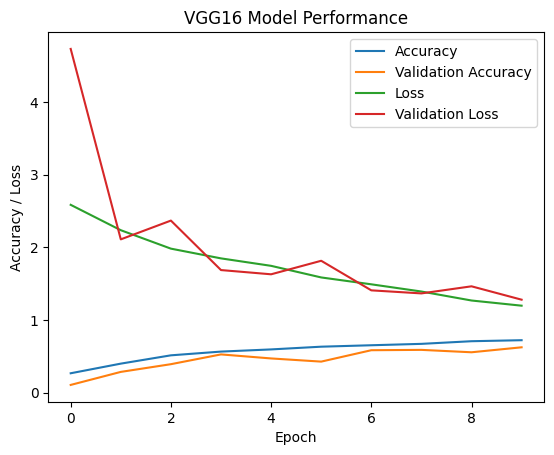

In [27]:
def plot_model_history(history: Dict[str, list], title: str = "Model Performance") -> None:
    """
    Plot the accuracy and loss history of a model.

    Parameters:
    - history (Dict[str, list]): Model training history containing 'accuracy', 'val_accuracy', 'loss', and 'val_loss'.
    - title (str): Title of the plot. Default is "Model Performance".

    Returns:
    None
    """
    # Plot accuracy
    plt.plot(history.history["accuracy"])
    plt.plot(history.history['val_accuracy'])

    # Plot loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])

    # Set plot attributes
    plt.title(title)
    plt.ylabel("Accuracy / Loss")
    plt.xlabel("Epoch")
    plt.legend(["Accuracy", "Validation Accuracy", "Loss", "Validation Loss"])
    plt.show()

# Example usage:
plot_model_history(history_vgg16, title="VGG16 Model Performance")


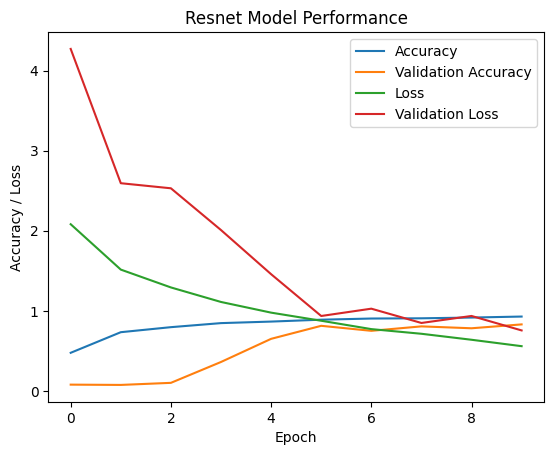

In [28]:
plot_model_history(history_resnet50, title="Resnet Model Performance")

1/1 [==============================] - 0s 24ms/step


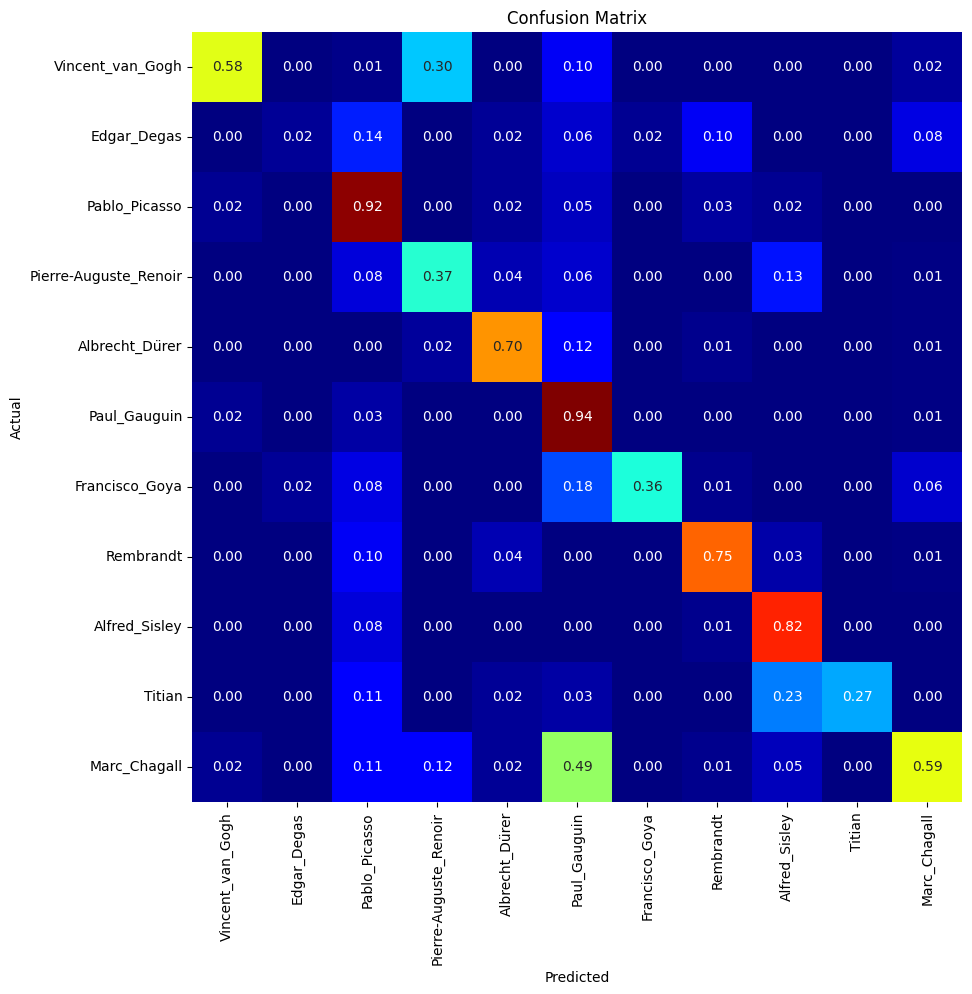

Classification Report:
                       precision    recall  f1-score   support

     Vincent_van_Gogh       0.93      0.58      0.72        65
          Edgar_Degas       0.50      0.02      0.04        49
        Pablo_Picasso       0.56      0.92      0.70       132
Pierre-Auguste_Renoir       0.46      0.37      0.41        43
      Albrecht_Dürer       0.80      0.70      0.75        47
         Paul_Gauguin       0.46      0.94      0.61        93
       Francisco_Goya       0.96      0.36      0.52        64
            Rembrandt       0.81      0.75      0.78        72
        Alfred_Sisley       0.64      0.82      0.72        60
               Titian       1.00      0.27      0.43        44
         Marc_Chagall       0.76      0.59      0.66       174

             accuracy                           0.64       843
            macro avg       0.71      0.58      0.58       843
         weighted avg       0.70      0.64      0.61       843



In [32]:
def show_classification_report_and_confusion_matrix(model, valid_generator, STEP_SIZE_VALID, n_classes, artists_top_name):
    """
    Display the classification report and confusion matrix for a given model and validation generator.

    Parameters:
    - model: The trained model.
    - valid_generator: The validation generator.
    - STEP_SIZE_VALID: Number of steps (batches) per validation epoch.
    - n_classes: Number of output classes.
    - artists_top_name: List of artist names.

    Returns:
    None
    """
    # Loop on each generator batch and predict
    y_pred, y_true = [], []
    for _ in range(STEP_SIZE_VALID):
        (X, y) = next(valid_generator)
        y_pred.append(model.predict(X))
        y_true.append(y)

    # Create a flat list for y_true and y_pred
    y_pred = [subresult for result in y_pred for subresult in result]
    y_true = [subresult for result in y_true for subresult in result]

    # Update Truth vector based on argmax
    y_true = np.argmax(y_true, axis=1)
    y_true = np.asarray(y_true).ravel()

    # Update Prediction vector based on argmax
    y_pred = np.argmax(y_pred, axis=1)
    y_pred = np.asarray(y_pred).ravel()

    # Confusion Matrix
    fig, ax = plt.subplots(figsize=(10, 10))
    conf_matrix = confusion_matrix(y_true, y_pred, labels=np.arange(n_classes))
    conf_matrix = conf_matrix / np.sum(conf_matrix, axis=1)
    sns.heatmap(conf_matrix, annot=True, fmt=".2f", square=True, cbar=False,
                cmap=plt.cm.jet, xticklabels=artists_top_name, yticklabels=artists_top_name,
                ax=ax)
    ax.set_ylabel('Actual')
    ax.set_xlabel('Predicted')
    ax.set_title('Confusion Matrix')
    plt.show()

    # Classification Report
    print('Classification Report:')
    print(classification_report(y_true, y_pred, labels=np.arange(n_classes), target_names=artists_top_name))

show_classification_report_and_confusion_matrix(model_vgg16, validation_generator, STEP_SIZE_VALID, n_classes, artists_top_name)


1/1 [==============================] - 0s 28ms/step


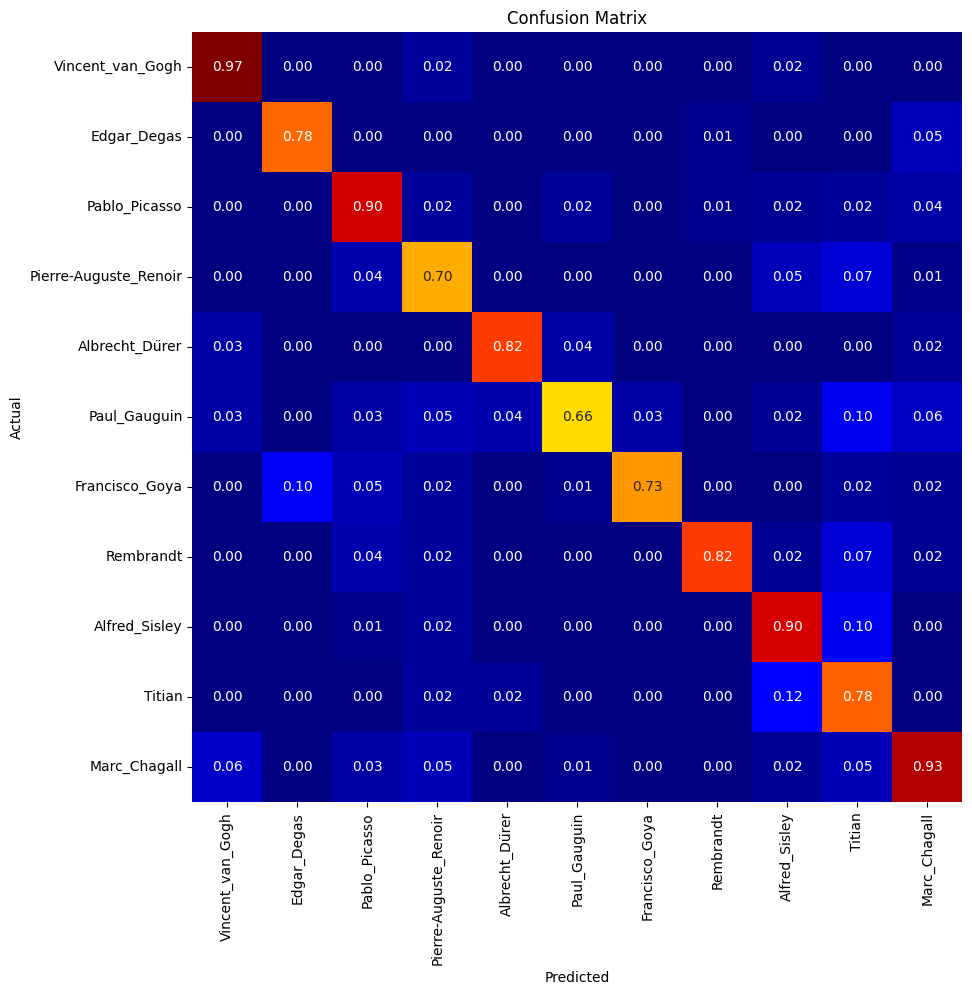

Classification Report:
                       precision    recall  f1-score   support

     Vincent_van_Gogh       0.89      0.97      0.93        65
          Edgar_Degas       0.88      0.78      0.83        49
        Pablo_Picasso       0.82      0.90      0.86       130
Pierre-Auguste_Renoir       0.76      0.70      0.73        44
      Albrecht_Dürer       0.93      0.82      0.87        50
         Paul_Gauguin       0.89      0.66      0.76        82
       Francisco_Goya       0.96      0.73      0.83        62
            Rembrandt       0.97      0.82      0.89        72
        Alfred_Sisley       0.78      0.90      0.83        58
               Titian       0.64      0.78      0.70        41
         Marc_Chagall       0.81      0.93      0.87       190

             accuracy                           0.84       843
            macro avg       0.85      0.82      0.83       843
         weighted avg       0.85      0.84      0.84       843



In [33]:
show_classification_report_and_confusion_matrix(model_resnet50, validation_generator, STEP_SIZE_VALID, n_classes, artists_top_name)


# Prediction

<ipython-input-36-9c9f735a9e33>:15: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  web_image = imageio.imread(url)


1/1 [==============================] - 0s 245ms/step
Predicted artist = Titian
Prediction probability = 26.126688718795776 %


<ipython-input-36-9c9f735a9e33>:37: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  plt.imshow(imageio.imread(url))


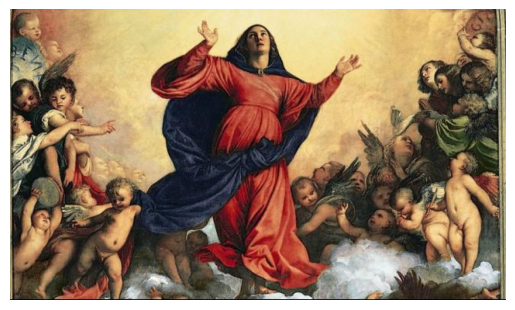

In [36]:
def predict_artist(url: str, model: Model, train_input_shape: tuple[int, int, int]) -> None:
    """
    Predict the artist of an image from a given URL using a pre-trained model.

    Parameters:
    - url (str): URL of the image to be predicted.
    - model (Model): Pre-trained Keras model for artist prediction.
    - train_input_shape (tuple): Input shape of the training data (height, width, channels).


    Returns:
    None
    """
    # Read and preprocess the web image
    web_image = imageio.imread(url)
    web_image = cv2.resize(web_image, dsize=train_input_shape[0:2])
    web_image = image.img_to_array(web_image)
    web_image /= 255.
    web_image = np.expand_dims(web_image, axis=0)

    labels = train_generator.class_indices
    labels = dict((v,k) for k,v in labels.items())

    # Make predictions using the model
    prediction = model.predict(web_image)
    prediction_probability = np.amax(prediction)
    prediction_idx = np.argmax(prediction)

    # Map the index to the corresponding artist label
    predicted_artist = labels[prediction_idx].replace('_', ' ')

    # Display the prediction results
    print("Predicted artist =", predicted_artist)
    print("Prediction probability =", prediction_probability * 100, "%")

    # Display the image
    plt.imshow(imageio.imread(url))
    plt.axis('off')
    plt.show()



# Define the URL of the image
url = 'https://www.gpsmycity.com/img/gd/2081.jpg'

# Call the function to predict the artist
predict_artist(url, model_vgg16, (224, 224, 3))
